# IPL Win Probabilty Predictor

**IPL match predictor is a ML based prediction approach where the data sets and previous stats are trained in all dimensions covering all important factors**

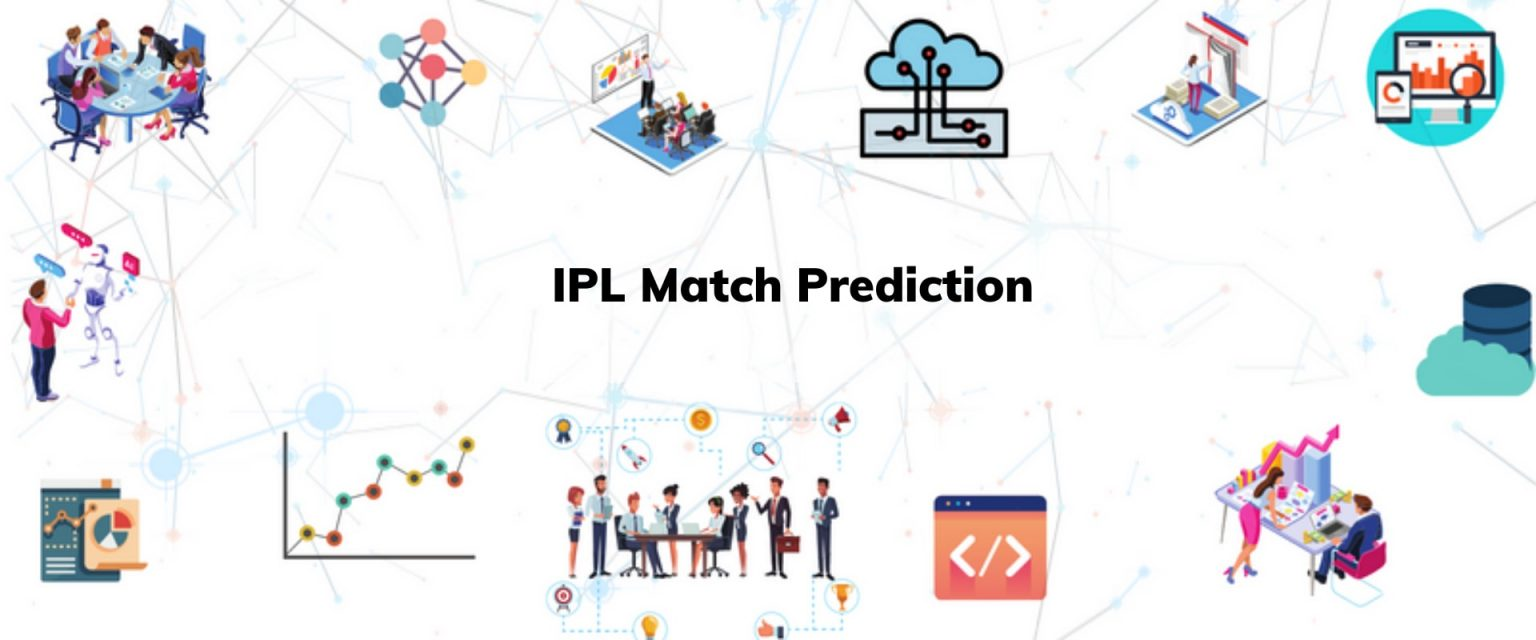

In [ ]:
#import all the important libraries used for Data processing
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

from scipy import stats
from scipy.stats import probplot

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline



from sklearn.preprocessing import OneHotEncoder,LabelEncoder,OrdinalEncoder 
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.feature_selection import SelectKBest,chi2


from sklearn import set_config

from sklearn.linear_model import LogisticRegression   
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score
 

import warnings
warnings.filterwarnings("ignore")

In [2]:
#downloading all the required dataset from kaggle 
#link for csv files are follows
#for deliveries dataset - https://www.kaggle.com/datasets/ramjidoolla/ipl-data-set?select=deliveries.csv
#for match dataset - https://www.kaggle.com/datasets/ramjidoolla/ipl-data-set?select=matches.csv

deliveries = pd.read_csv('deliveries_.csv')
matches    = pd.read_csv('matches.csv')
print('The shape of the deliveries dataframe is :', deliveries.shape)
print('The shape of the matches dataframe is :', matches.shape)


The shape of the deliveries dataframe is : (179078, 21)
The shape of the matches dataframe is : (756, 18)


In [3]:
#check for the first five rows of matches dataframe
matches.head()
#Provide the data of each matches that has been played from the year of 2008 to 2019
#Each row represent the details of the column depicting in the check of first five rows

,id,Season,city,date,team1,team2,toss_winner,toss_decision,result,dl_applied,winner,win_by_runs,win_by_wickets,player_of_match,venue,umpire1,umpire2,umpire3
0,1,IPL-2017,Hyderabad,05-04-2017,Sunrisers Hyderabad,Royal Challengers Bangalore,Royal Challengers Bangalore,field,normal,0,Sunrisers Hyderabad,35,0,Yuvraj Singh,"Rajiv Gandhi International Stadium, Uppal",AY Dandekar,NJ Llong,NaN
1,2,IPL-2017,Pune,06-04-2017,Mumbai Indians,Rising Pune Supergiant,Rising Pune Supergiant,field,normal,0,Rising Pune Supergiant,0,7,SPD Smith,Maharashtra Cricket Association Stadium,A Nand Kishore,S Ravi,NaN
2,3,IPL-2017,Rajkot,07-04-2017,Gujarat Lions,Kolkata Knight Riders,Kolkata Knight Riders,field,normal,0,Kolkata Knight Riders,0,10,CA Lynn,Saurashtra Cricket Association Stadium,Nitin Menon,CK Nandan,NaN
3,4,IPL-2017,Indore,08-04-2017,Rising Pune Supergiant,Kings XI Punjab,Kings XI Punjab,field,normal,0,Kings XI Punjab,0,6,GJ Maxwell,Holkar Cricket Stadium,AK Chaudhary,C Shamshuddin,NaN
4,5,IPL-2017,Bangalore,08-04-2017,Royal Challengers Bangalore,Delhi Daredevils,Royal Challengers Bangalore,bat,normal,0,Royal Challengers Bangalore,15,0,KM Jadhav,M Chinnaswamy Stadium,NaN,NaN,NaN


In [4]:
#check for first five rows of deliveries dataframe
deliveries.head()
#provide the data ballwise played in all the matches that has been played frm the year of 2008 to 2019.
#Each row represent the details of the column depicting in the check of first five rows

,match_id,inning,batting_team,bowling_team,over,ball,batsman,non_striker,bowler,is_super_over,...,bye_runs,legbye_runs,noball_runs,penalty_runs,batsman_runs,extra_runs,total_runs,player_dismissed,dismissal_kind,fielder
0,1,1,Sunrisers Hyderabad,Royal Challengers Bangalore,1,1,DA Warner,S Dhawan,TS Mills,0,...,0,0,0,0,0,0,0,NaN,NaN,NaN
1,1,1,Sunrisers Hyderabad,Royal Challengers Bangalore,1,2,DA Warner,S Dhawan,TS Mills,0,...,0,0,0,0,0,0,0,NaN,NaN,NaN
2,1,1,Sunrisers Hyderabad,Royal Challengers Bangalore,1,3,DA Warner,S Dhawan,TS Mills,0,...,0,0,0,0,4,0,4,NaN,NaN,NaN
3,1,1,Sunrisers Hyderabad,Royal Challengers Bangalore,1,4,DA Warner,S Dhawan,TS Mills,0,...,0,0,0,0,0,0,0,NaN,NaN,NaN
4,1,1,Sunrisers Hyderabad,Royal Challengers Bangalore,1,5,DA Warner,S Dhawan,TS Mills,0,...,0,0,0,0,0,2,2,NaN,NaN,NaN


### As per the prediction model expected we require five feature extraction from the above two dataset:
- batting_team 
- bowling_team 
- city (where corresponding match was played)
- runs_lefts (pending runs to win the match after that corresponding ball during the second innings)
- balls_left (pending balls that can be played after that corresponding ball during the second innings) 
- wickets_left (No of wickets left of the batting team in the second innings at that state of time)
- total_runs_x (Represent the target runs to secure i.e first inning score)
- ccr (Current run rate)
- rrr (required run rate)
- result (whether the match was win by the current team at the corresponding ball)

Based upon above our machine learning program will be trained to predict the probability of the match winner team.

We need to fetch the above feature.

In [5]:
#as the final dataframe which will have the required data is deliveries so we will fetch the required data from matches 
#and merge the same with deliveries dataframe

delivery_df_totalRuns_match = deliveries.groupby(['match_id','inning']).sum()['total_runs'].reset_index()
delivery_df_totalRuns_match_inning1 = delivery_df_totalRuns_match[delivery_df_totalRuns_match['inning'] ==1]
delivery_df_totalRuns_match_inning1.head()


,match_id,inning,total_runs
0,1,1,207
2,2,1,184
4,3,1,183
6,4,1,163
8,5,1,157


In [6]:
#in the below dataframe total_runs implies the run scored in the first inning of each match and match_id is the unique Match no
matches_df = matches.merge(delivery_df_totalRuns_match_inning1[['match_id','total_runs']],left_on='id',right_on='match_id')
print('The shape of matches_df is:',matches_df.shape)
matches_df.head()

The shape of matches_df is: (756, 20)


,id,Season,city,date,team1,team2,toss_winner,toss_decision,result,dl_applied,winner,win_by_runs,win_by_wickets,player_of_match,venue,umpire1,umpire2,umpire3,match_id,total_runs
0,1,IPL-2017,Hyderabad,05-04-2017,Sunrisers Hyderabad,Royal Challengers Bangalore,Royal Challengers Bangalore,field,normal,0,Sunrisers Hyderabad,35,0,Yuvraj Singh,"Rajiv Gandhi International Stadium, Uppal",AY Dandekar,NJ Llong,NaN,1,207
1,2,IPL-2017,Pune,06-04-2017,Mumbai Indians,Rising Pune Supergiant,Rising Pune Supergiant,field,normal,0,Rising Pune Supergiant,0,7,SPD Smith,Maharashtra Cricket Association Stadium,A Nand Kishore,S Ravi,NaN,2,184
2,3,IPL-2017,Rajkot,07-04-2017,Gujarat Lions,Kolkata Knight Riders,Kolkata Knight Riders,field,normal,0,Kolkata Knight Riders,0,10,CA Lynn,Saurashtra Cricket Association Stadium,Nitin Menon,CK Nandan,NaN,3,183
3,4,IPL-2017,Indore,08-04-2017,Rising Pune Supergiant,Kings XI Punjab,Kings XI Punjab,field,normal,0,Kings XI Punjab,0,6,GJ Maxwell,Holkar Cricket Stadium,AK Chaudhary,C Shamshuddin,NaN,4,163
4,5,IPL-2017,Bangalore,08-04-2017,Royal Challengers Bangalore,Delhi Daredevils,Royal Challengers Bangalore,bat,normal,0,Royal Challengers Bangalore,15,0,KM Jadhav,M Chinnaswamy Stadium,NaN,NaN,NaN,5,157


In [7]:
#creating a list of teams that are playing now in order to predict the presently playing winning team 
teams = ['Sunrisers Hyderabad', 'Mumbai Indians', 
        'Royal Challengers Bangalore',
       'Kolkata Knight Riders', 'Kings XI Punjab',
       'Chennai Super Kings', 'Rajasthan Royals',
       'Delhi Capitals']

In [8]:
#since the name of team of Delhi Daredevils has been changed to Delhi capitals we are changing the name of team for better prediction
#Similary the name of Deccan Chargers are changed to Sunrise Hyderabad in order to avoid further miscommunication 
matches_df['team1'] = matches_df['team1'].apply(lambda x : 'Delhi Capitals' if x == 'Delhi Daredevils' else x )
matches_df['team2'] = matches_df['team2'].apply(lambda x : 'Delhi Capitals' if x == 'Delhi Daredevils' else x )
matches_df['winner'] = matches_df['winner'].apply(lambda x : 'Delhi Capitals' if x == 'Delhi Daredevils' else x )


matches_df['team1'] = matches_df['team1'].apply(lambda x : 'Sunrisers Hyderabad' if x == 'Deccan Chargers' else x )
matches_df['team2'] = matches_df['team2'].apply(lambda x : 'Sunrisers Hyderabad' if x == 'Deccan Chargers' else x )
matches_df['winner'] = matches_df['winner'].apply(lambda x : 'Sunrisers Hyderabad' if x == 'Deccan Chargers' else x )




In [9]:
#Since now we have only seven teams (name mentioned in teams list) playing in the IPL so we can remove the other teams from the datasets
matches_df = matches_df[matches_df.team1.isin(teams)]
matches_df = matches_df[matches_df.team2.isin(teams)]
print('The shape of matches_df after removing the present not playing teams comes out to be :', matches_df.shape)

The shape of matches_df after removing the present not playing teams comes out to be : (641, 20)


In [10]:
#removing the dlapplied matches as the same is based on the weather condition matches.
#Since our predictive model should be based on efficiency of teams so we remove them
matches_df = matches_df[matches_df.dl_applied==0]
print('The shape of matches_df after removing the dl_applied matches :', matches_df.shape)

The shape of matches_df after removing the dl_applied matches : (626, 20)


In [11]:
#applying the same condition for delivery Dataframe as well
deliveries['batting_team'] = deliveries.batting_team.apply(lambda x : 'Delhi Capitals' if x == 'Delhi Daredevils' else x )
deliveries['bowling_team'] = deliveries.bowling_team.apply(lambda x : 'Delhi Capitals' if x == 'Delhi Daredevils' else x )

deliveries['batting_team'] = deliveries.batting_team.apply(lambda x : 'Sunrisers Hyderabad' if x == 'Deccan Chargers' else x )
deliveries['bowling_team'] = deliveries.bowling_team.apply(lambda x : 'Sunrisers Hyderabad' if x == 'Deccan Chargers' else x )



In [12]:
#merging the required details from match_df with the deliveries dataframe
#total_run_x defines the total run scored during inning 1 of each corres match
#total_run_y defines the run scored during the said inning and mentioned ball of corresponding over

matches_df = matches_df[['match_id','city','winner','total_runs']]
delivery_df = matches_df.merge(deliveries,on='match_id')
delivery_df = delivery_df[delivery_df.inning == 2]
print('The shape of delivery_df comes out to be :', delivery_df.shape)

The shape of delivery_df comes out to be : (72413, 24)


In [13]:
#fetching out the runs_left feature from delivery_df dataframe corresponding to each ball 
delivery_df['runs_left'] = delivery_df.total_runs_x - delivery_df.groupby('match_id').cumsum()['total_runs_y'] +1

In [14]:
#fetching out the ball_left feature from delivery_df dataframe corresponding to each ball
delivery_df['balls_left'] = 126 - delivery_df['over']*6 - delivery_df['ball']
delivery_df.head()

,match_id,city,winner,total_runs_x,inning,batting_team,bowling_team,over,ball,batsman,...,noball_runs,penalty_runs,batsman_runs,extra_runs,total_runs_y,player_dismissed,dismissal_kind,fielder,runs_left,balls_left
125,1,Hyderabad,Sunrisers Hyderabad,207,2,Royal Challengers Bangalore,Sunrisers Hyderabad,1,1,CH Gayle,...,0,0,1,0,1,NaN,NaN,NaN,207,119
126,1,Hyderabad,Sunrisers Hyderabad,207,2,Royal Challengers Bangalore,Sunrisers Hyderabad,1,2,Mandeep Singh,...,0,0,0,0,0,NaN,NaN,NaN,207,118
127,1,Hyderabad,Sunrisers Hyderabad,207,2,Royal Challengers Bangalore,Sunrisers Hyderabad,1,3,Mandeep Singh,...,0,0,0,0,0,NaN,NaN,NaN,207,117
128,1,Hyderabad,Sunrisers Hyderabad,207,2,Royal Challengers Bangalore,Sunrisers Hyderabad,1,4,Mandeep Singh,...,0,0,2,0,2,NaN,NaN,NaN,205,116
129,1,Hyderabad,Sunrisers Hyderabad,207,2,Royal Challengers Bangalore,Sunrisers Hyderabad,1,5,Mandeep Singh,...,0,0,4,0,4,NaN,NaN,NaN,201,115


In [15]:
#fetching out the wicket_left feature from delivery_df dataframe corresponding to each ball
#check for the first five item in the delivery_df
delivery_df['player_dismissed'] = delivery_df['player_dismissed'].fillna(0)
delivery_df['player_dismissed'] = delivery_df['player_dismissed'].apply(lambda x : 0 if x == 0 else 1)
delivery_df['wickets_left'] = 10- delivery_df.groupby('match_id').cumsum()['player_dismissed']
delivery_df.head()

,match_id,city,winner,total_runs_x,inning,batting_team,bowling_team,over,ball,batsman,...,penalty_runs,batsman_runs,extra_runs,total_runs_y,player_dismissed,dismissal_kind,fielder,runs_left,balls_left,wickets_left
125,1,Hyderabad,Sunrisers Hyderabad,207,2,Royal Challengers Bangalore,Sunrisers Hyderabad,1,1,CH Gayle,...,0,1,0,1,0,NaN,NaN,207,119,10
126,1,Hyderabad,Sunrisers Hyderabad,207,2,Royal Challengers Bangalore,Sunrisers Hyderabad,1,2,Mandeep Singh,...,0,0,0,0,0,NaN,NaN,207,118,10
127,1,Hyderabad,Sunrisers Hyderabad,207,2,Royal Challengers Bangalore,Sunrisers Hyderabad,1,3,Mandeep Singh,...,0,0,0,0,0,NaN,NaN,207,117,10
128,1,Hyderabad,Sunrisers Hyderabad,207,2,Royal Challengers Bangalore,Sunrisers Hyderabad,1,4,Mandeep Singh,...,0,2,0,2,0,NaN,NaN,205,116,10
129,1,Hyderabad,Sunrisers Hyderabad,207,2,Royal Challengers Bangalore,Sunrisers Hyderabad,1,5,Mandeep Singh,...,0,4,0,4,0,NaN,NaN,201,115,10


In [16]:
#check for the last five item in the delivery_df
delivery_df.tail()

,match_id,city,winner,total_runs_x,inning,batting_team,bowling_team,over,ball,batsman,...,penalty_runs,batsman_runs,extra_runs,total_runs_y,player_dismissed,dismissal_kind,fielder,runs_left,balls_left,wickets_left
149573,11415,Hyderabad,Mumbai Indians,152,2,Chennai Super Kings,Mumbai Indians,20,2,RA Jadeja,...,0,1,0,1,0,NaN,NaN,1,4,5
149574,11415,Hyderabad,Mumbai Indians,152,2,Chennai Super Kings,Mumbai Indians,20,3,SR Watson,...,0,2,0,2,0,NaN,NaN,-1,3,5
149575,11415,Hyderabad,Mumbai Indians,152,2,Chennai Super Kings,Mumbai Indians,20,4,SR Watson,...,0,1,0,1,1,run out,KH Pandya,-2,2,4
149576,11415,Hyderabad,Mumbai Indians,152,2,Chennai Super Kings,Mumbai Indians,20,5,SN Thakur,...,0,2,0,2,0,NaN,NaN,-4,1,4
149577,11415,Hyderabad,Mumbai Indians,152,2,Chennai Super Kings,Mumbai Indians,20,6,SN Thakur,...,0,0,0,0,1,lbw,NaN,-4,0,3


In [17]:
#calculate the current run rate required feature (crr)
##crr = current_runs_secured/current_over_played

delivery_df['crr'] = (delivery_df.groupby('match_id').cumsum()['total_runs_y']*6)/(120 - delivery_df.balls_left)
delivery_df.head()

,match_id,city,winner,total_runs_x,inning,batting_team,bowling_team,over,ball,batsman,...,batsman_runs,extra_runs,total_runs_y,player_dismissed,dismissal_kind,fielder,runs_left,balls_left,wickets_left,crr
125,1,Hyderabad,Sunrisers Hyderabad,207,2,Royal Challengers Bangalore,Sunrisers Hyderabad,1,1,CH Gayle,...,1,0,1,0,NaN,NaN,207,119,10,6.0
126,1,Hyderabad,Sunrisers Hyderabad,207,2,Royal Challengers Bangalore,Sunrisers Hyderabad,1,2,Mandeep Singh,...,0,0,0,0,NaN,NaN,207,118,10,3.0
127,1,Hyderabad,Sunrisers Hyderabad,207,2,Royal Challengers Bangalore,Sunrisers Hyderabad,1,3,Mandeep Singh,...,0,0,0,0,NaN,NaN,207,117,10,2.0
128,1,Hyderabad,Sunrisers Hyderabad,207,2,Royal Challengers Bangalore,Sunrisers Hyderabad,1,4,Mandeep Singh,...,2,0,2,0,NaN,NaN,205,116,10,4.5
129,1,Hyderabad,Sunrisers Hyderabad,207,2,Royal Challengers Bangalore,Sunrisers Hyderabad,1,5,Mandeep Singh,...,4,0,4,0,NaN,NaN,201,115,10,8.4


In [18]:
#calculate the required run rate required feature (rrr)
##rrr = run_left_to_win_match/over_left

delivery_df['rrr'] = (delivery_df.runs_left*6)/(delivery_df.balls_left)

In [19]:
#Calculate the result of the match
##The same be based on current inning details i.e 1 if the current inning team wins else 0

def result(data):
    return 1 if data['batting_team'] == data['winner'] else 0

delivery_df['result'] = delivery_df.apply(result,axis=1)
delivery_df.head()

,match_id,city,winner,total_runs_x,inning,batting_team,bowling_team,over,ball,batsman,...,total_runs_y,player_dismissed,dismissal_kind,fielder,runs_left,balls_left,wickets_left,crr,rrr,result
125,1,Hyderabad,Sunrisers Hyderabad,207,2,Royal Challengers Bangalore,Sunrisers Hyderabad,1,1,CH Gayle,...,1,0,NaN,NaN,207,119,10,6.0,10.436975,0
126,1,Hyderabad,Sunrisers Hyderabad,207,2,Royal Challengers Bangalore,Sunrisers Hyderabad,1,2,Mandeep Singh,...,0,0,NaN,NaN,207,118,10,3.0,10.525424,0
127,1,Hyderabad,Sunrisers Hyderabad,207,2,Royal Challengers Bangalore,Sunrisers Hyderabad,1,3,Mandeep Singh,...,0,0,NaN,NaN,207,117,10,2.0,10.615385,0
128,1,Hyderabad,Sunrisers Hyderabad,207,2,Royal Challengers Bangalore,Sunrisers Hyderabad,1,4,Mandeep Singh,...,2,0,NaN,NaN,205,116,10,4.5,10.603448,0
129,1,Hyderabad,Sunrisers Hyderabad,207,2,Royal Challengers Bangalore,Sunrisers Hyderabad,1,5,Mandeep Singh,...,4,0,NaN,NaN,201,115,10,8.4,10.486957,0


In [20]:
#fetching out the required feature from delivery_df for further traning of model
final_df = delivery_df[['batting_team','bowling_team','city','runs_left','balls_left','wickets_left','total_runs_x','crr','rrr','result']]

In [21]:
#Shuffling the final_df in order to create randomness in the given dataset
final_df = final_df.sample(final_df.shape[0])
final_df.head()

,batting_team,bowling_team,city,runs_left,balls_left,wickets_left,total_runs_x,crr,rrr,result
130153,Royal Challengers Bangalore,Sunrisers Hyderabad,Hyderabad,87,70,8,155,8.280000,7.457143,0
75353,Rajasthan Royals,Kings XI Punjab,Jaipur,102,101,10,124,7.263158,6.059406,1
141784,Rajasthan Royals,Mumbai Indians,Mumbai,27,29,8,191,10.879121,5.586207,1
146802,Kings XI Punjab,Sunrisers Hyderabad,Hyderabad,212,104,9,232,7.875000,12.230769,0
27873,Chennai Super Kings,Rajasthan Royals,Kimberley,101,78,8,140,5.714286,7.769231,1


# Machine Learning Project Life cycle

1. Data Collection **(The same is collected from the available raw dataframes. Final_df is the dataframe in which model for prediction will trained)**
2. Data Preparation
    
    A. Exploratory Data Analysis (EDA)
        a.Univariate Analysis
        b.Multivariate Analysis
    B. Data Preprocessing
        a.Feature imputation
        b.Feature encoding
        c.Feature selection
        d.Handle imbalances
3. Model Building

    A. Choosing an algorithm        
    B. Hyperparameter Tuning         
    C. Performance metrics
    
4. Model Deployment

In [22]:
#check for datatype of the feature available in final_df
print('*'*125)
final_df.info()
##batting team, bowling_team and city has object('String') datatype. 
##runs_left,balls_left,wicket_left and result features has int datatype.
##crr and rrr features has float datatype.
print('*'*125)

*****************************************************************************************************************************
<class 'pandas.core.frame.DataFrame'>
Int64Index: 72413 entries, 130153 to 141069
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   batting_team  72413 non-null  object 
 1   bowling_team  72413 non-null  object 
 2   city          71581 non-null  object 
 3   runs_left     72413 non-null  int64  
 4   balls_left    72413 non-null  int64  
 5   wickets_left  72413 non-null  int64  
 6   total_runs_x  72413 non-null  int64  
 7   crr           72413 non-null  float64
 8   rrr           72408 non-null  float64
 9   result        72413 non-null  int64  
dtypes: float64(2), int64(5), object(3)
memory usage: 6.1+ MB
*****************************************************************************************************************************


In [23]:
#check for the stats figure of the final_df dataframe
print('*'*125)
final_df.describe()


*****************************************************************************************************************************


,runs_left,balls_left,wickets_left,total_runs_x,crr,rrr,result
count,72413.000000,72413.000000,72413.000000,72413.000000,72413.000000,7.240800e+04,72413.000000
mean,93.258379,62.657078,7.535967,165.583956,7.439523,NaN,0.525624
std,50.021962,33.404593,2.138637,29.282200,2.275850,NaN,0.499346
min,-15.000000,-2.000000,0.000000,65.000000,0.000000,-inf,0.000000
25%,54.000000,35.000000,6.000000,146.000000,6.257143,7.257143e+00,0.000000
50%,93.000000,63.000000,8.000000,165.000000,7.480519,9.000000e+00,1.000000
75%,131.000000,92.000000,9.000000,185.000000,8.682353,1.105263e+01,1.000000
max,250.000000,119.000000,10.000000,250.000000,42.000000,inf,1.000000


In [24]:
#check for null values
final_df.isnull().mean()*100
#1.14% data is missing in the city feature and 0.006905% data is missing in rrr feature. 
##Since we can't impute the city name where match was conducted based on other feature so we drop the NaN values in city feature.
## % of NaN values are very less so the same can be dropped. 

batting_team    0.000000
bowling_team    0.000000
city            1.148965
runs_left       0.000000
balls_left      0.000000
wickets_left    0.000000
total_runs_x    0.000000
crr             0.000000
rrr             0.006905
result          0.000000
dtype: float64

In [25]:
#Since rrr is having inf and -inf as max and min values as depicted during analysing the statistic of final_df
#This can be possible if the ball_left is 0
final_df = final_df[final_df.balls_left != 0]
final_df.shape

(72172, 10)

In [26]:
#dropping the NaN values in final_df
final_df.dropna(inplace=True)

In [27]:
#checking for describe after correcting the NaN and inf values present in the given dataset
final_df.describe()

,runs_left,balls_left,wickets_left,total_runs_x,crr,rrr,result
count,71342.000000,71342.000000,71342.000000,71342.000000,71342.000000,71342.000000,71342.000000
mean,93.621065,62.878725,7.553251,165.726963,7.447791,10.568474,0.526646
std,49.957572,33.259471,2.124334,29.294967,2.280498,14.041845,0.499293
min,-15.000000,-2.000000,0.000000,65.000000,0.000000,-516.000000,0.000000
25%,54.000000,35.000000,6.000000,147.000000,6.265782,7.267606,0.000000
50%,93.000000,64.000000,8.000000,165.000000,7.500000,9.000000,1.000000
75%,131.000000,92.000000,9.000000,185.000000,8.696385,11.032258,1.000000
max,250.000000,119.000000,10.000000,250.000000,42.000000,684.000000,1.000000


In [28]:
#function to get value_counts corresponding to unique categories 

def unique_categories(data):
    for col in data:
        if (data[col].dtype == 'object'):
            print(col,'\n-------')
            print(data[col].value_counts())
            print('='*100)
            print('='*100)
            
unique_categories(final_df)

batting_team 
-------
Delhi Capitals                 9919
Kolkata Knight Riders          9633
Royal Challengers Bangalore    9548
Mumbai Indians                 8911
Kings XI Punjab                8545
Rajasthan Royals               8397
Chennai Super Kings            8342
Sunrisers Hyderabad            8047
Name: batting_team, dtype: int64
bowling_team 
-------
Sunrisers Hyderabad            10828
Mumbai Indians                 10541
Kings XI Punjab                 9358
Chennai Super Kings             9303
Royal Challengers Bangalore     8391
Kolkata Knight Riders           8117
Delhi Capitals                  7575
Rajasthan Royals                7229
Name: bowling_team, dtype: int64
city 
-------
Mumbai            9874
Kolkata           7781
Delhi             7254
Hyderabad         6502
Chennai           6286
Bangalore         5910
Jaipur            4825
Chandigarh        4554
Durban            1719
Bengaluru         1604
Ahmedabad         1392
Pune              1318
Centurion       

# Exploratory Data Analysis

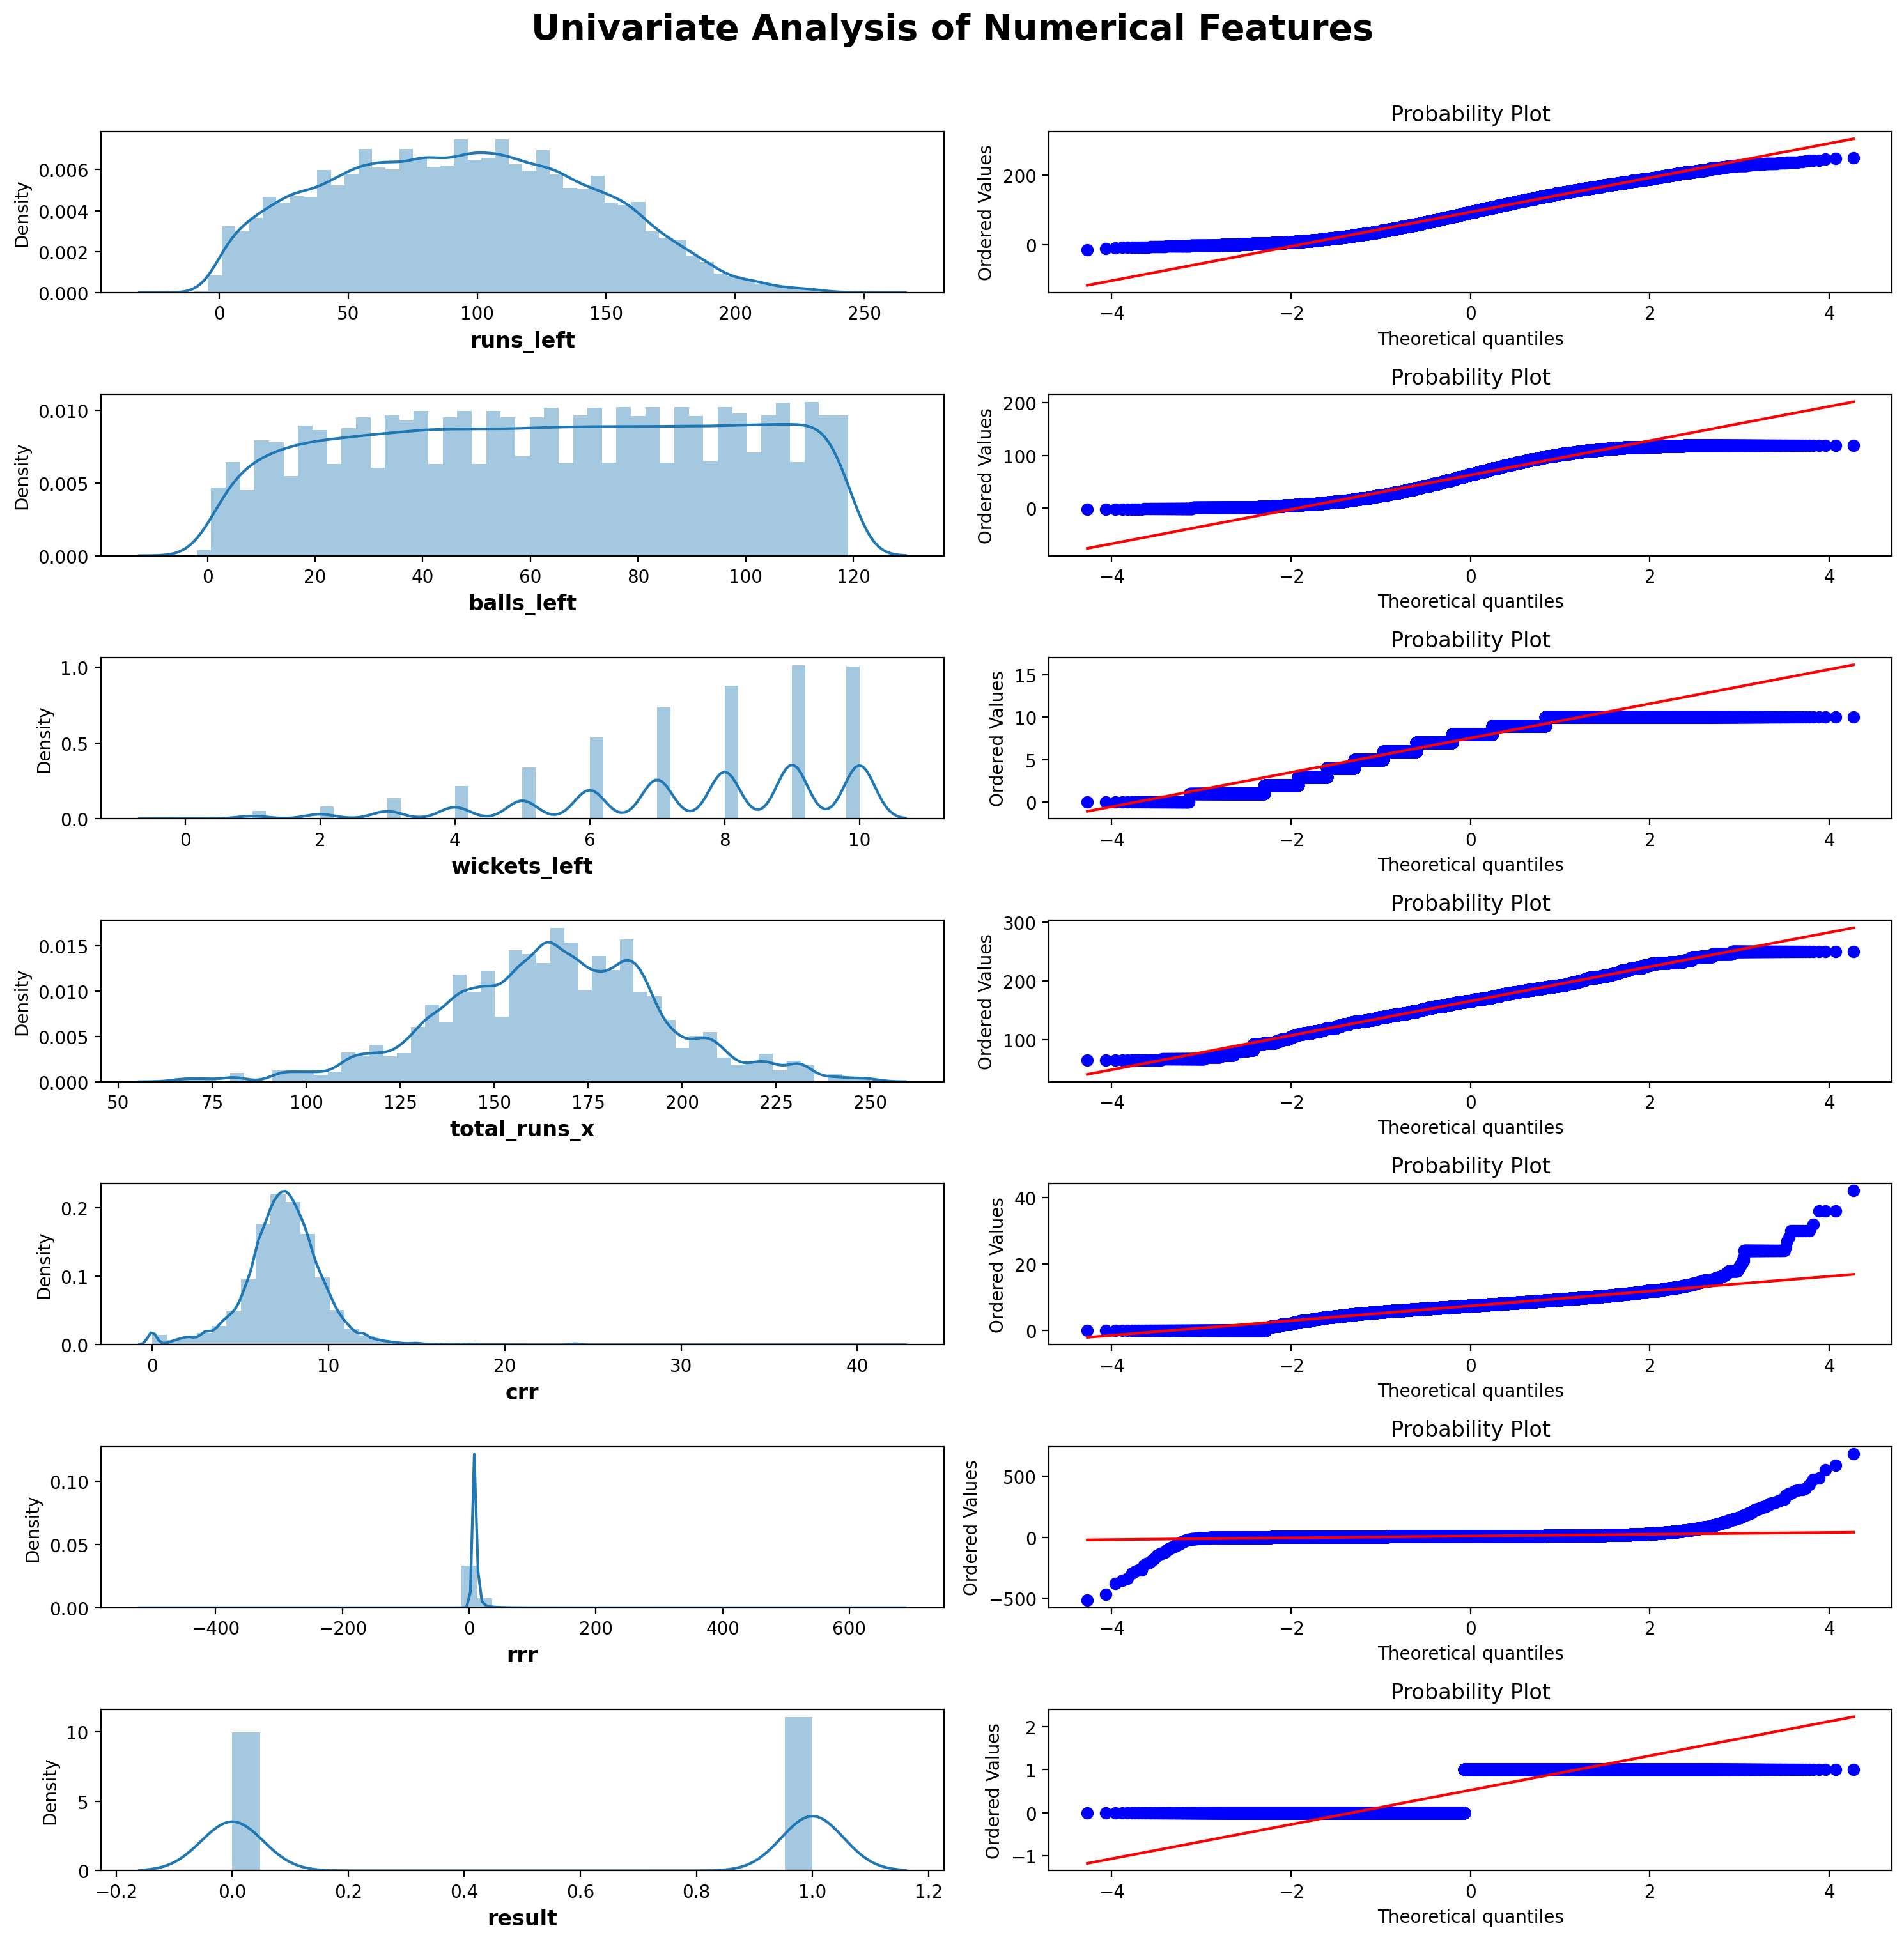

In [29]:
#ploting distplot and QQ plot for the numerical columns

def univariate_distplot_QQ_numerical(data):
    plt.figure(figsize =(15,15),dpi=200)
    plt.suptitle('Univariate Analysis of Numerical Features',fontsize=20, fontweight='bold',alpha=1, y=1.01)
    
    i=0
    for col in data:
        if data[col].dtype != 'object':
            plt.subplot(7,2,i+1)
            sns.distplot(data[col])
            plt.xlabel(col, fontdict={'fontsize':12,'fontweight':'bold'})
            
            plt.subplot(7,2,i+2)
            stats.probplot(data[col],dist='norm',plot=plt)
            plt.tight_layout()
            i+=2
            
univariate_distplot_QQ_numerical(final_df)

#none of the data was normally distributed except total_run_x

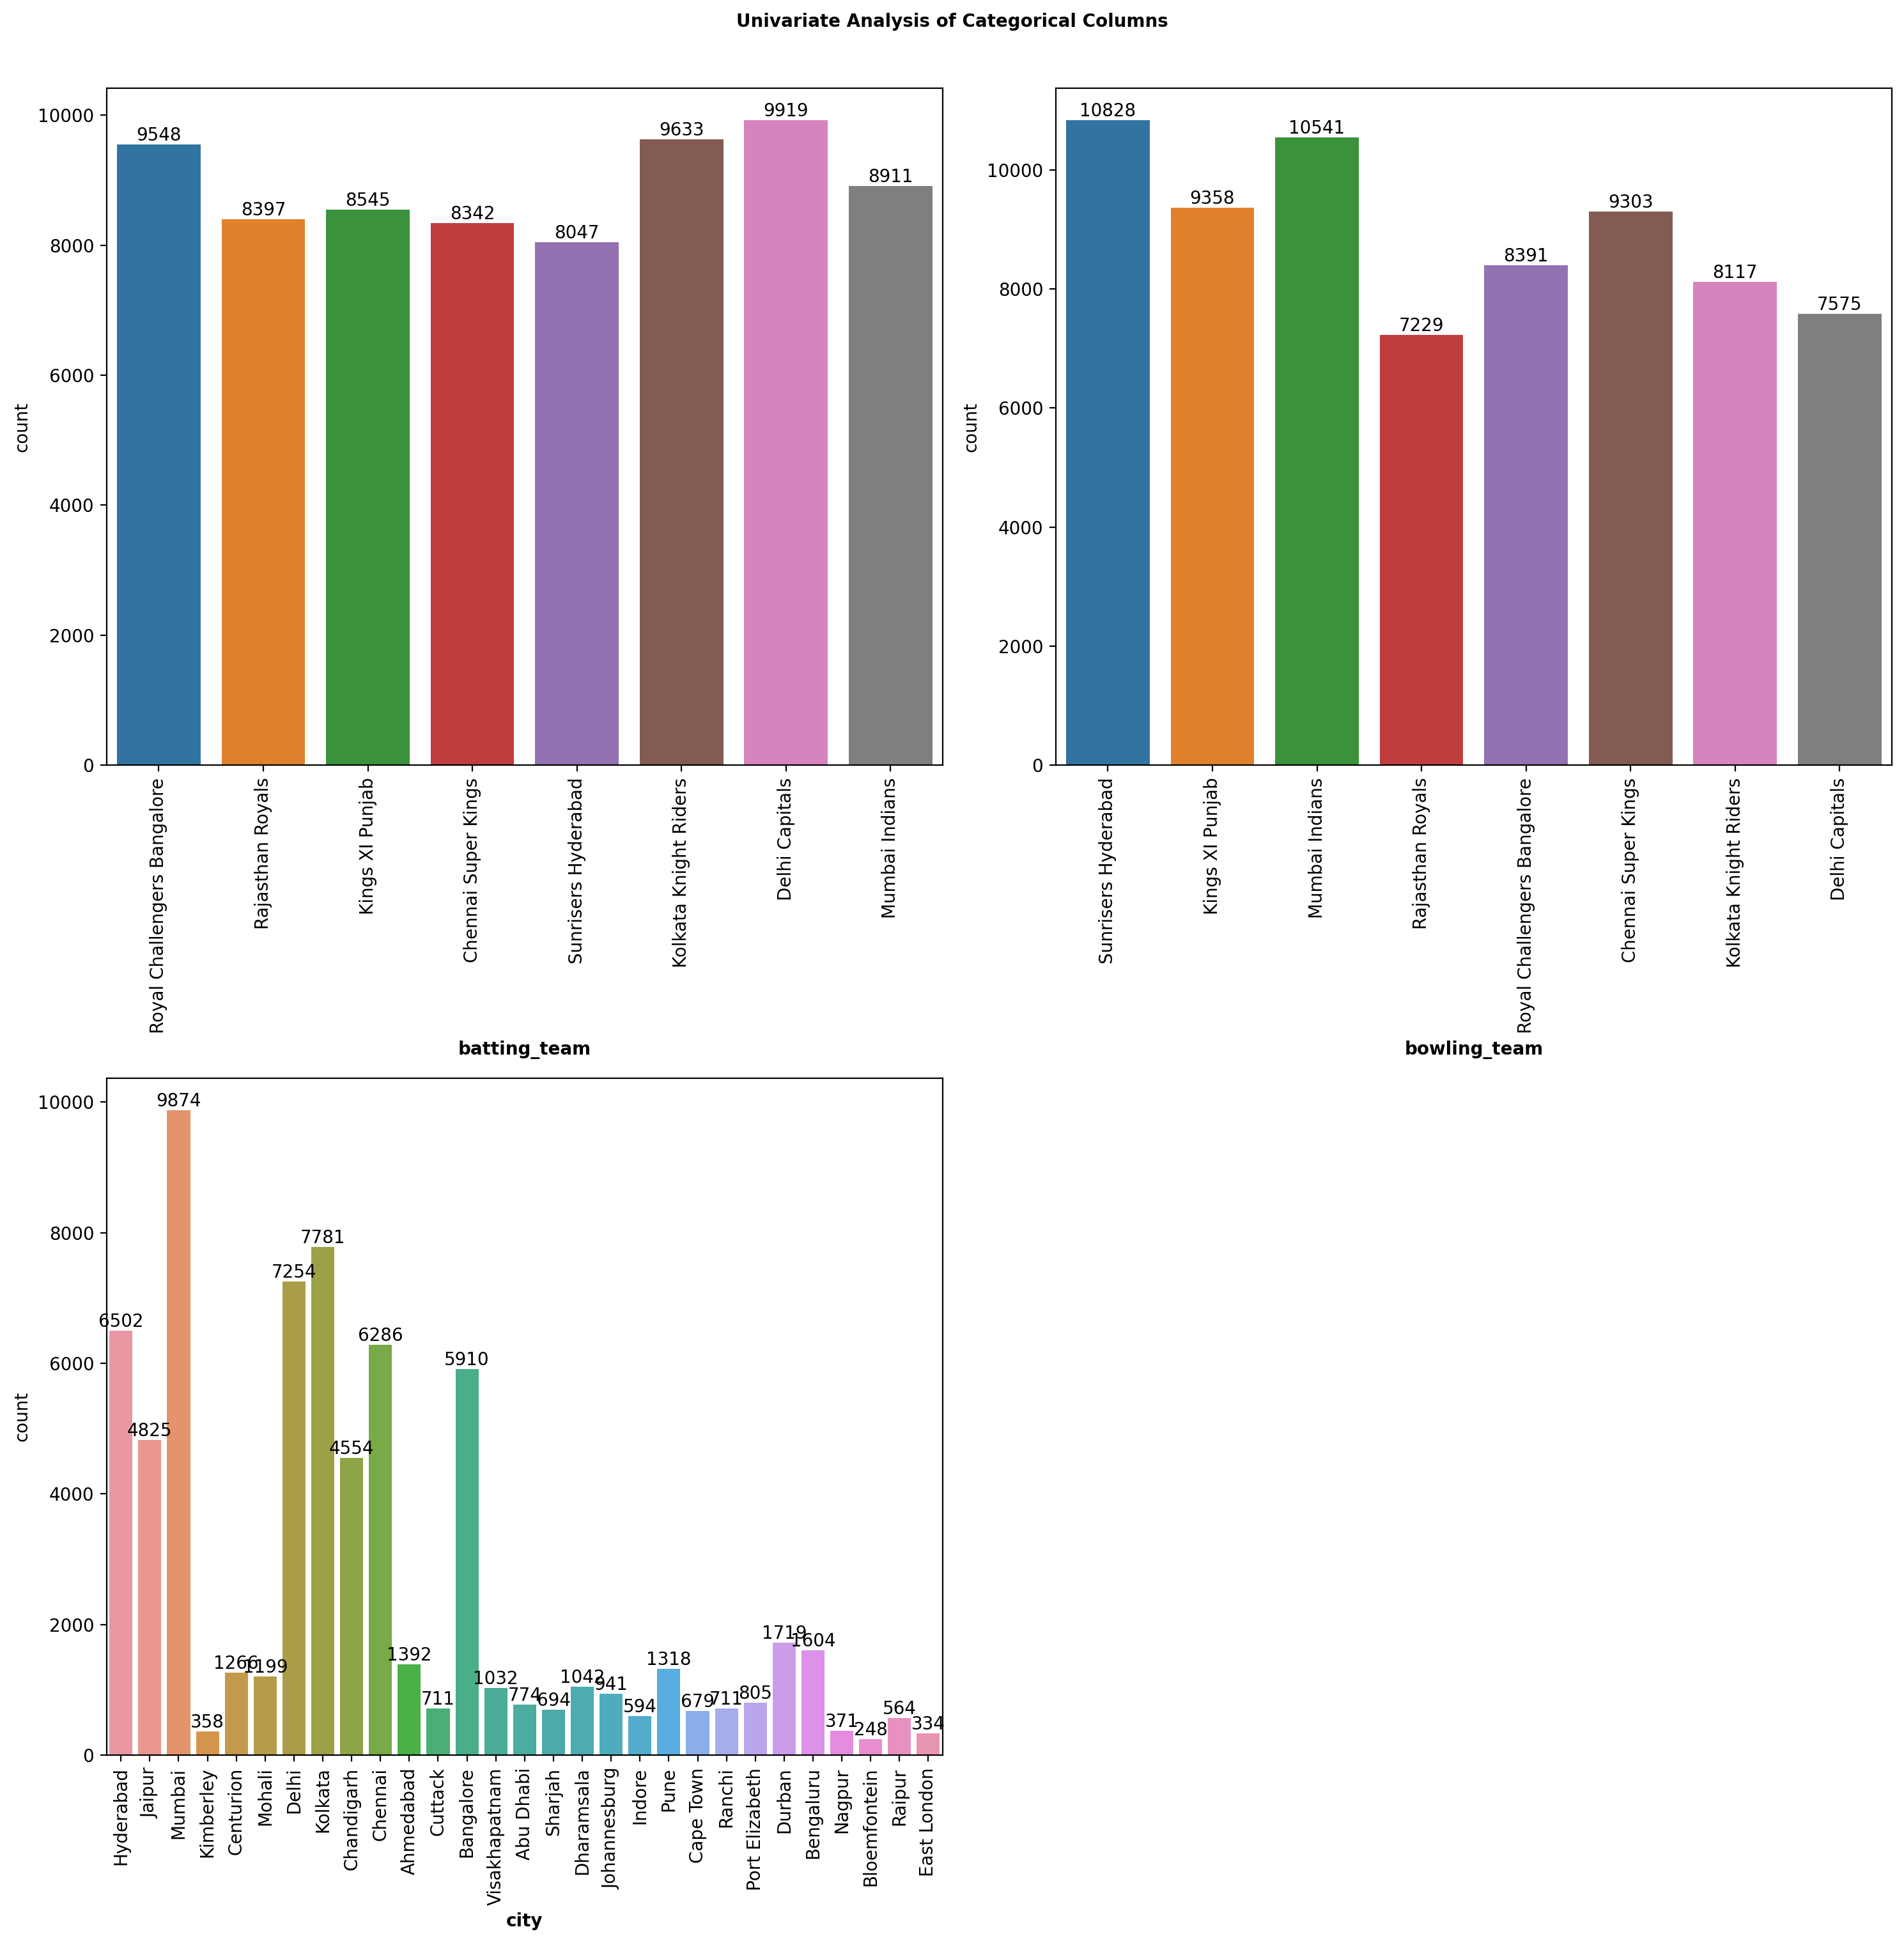

In [30]:
#plotting countplot for categorical columns

def univariate_plots_categorical(data):
    plt.figure(figsize=(15,15),dpi=200)
    plt.suptitle('Univariate Analysis of Categorical Columns',fontsize=10,fontweight='bold',alpha=1,y=1.01)
    
    i =0
    for col in data:
        if data[col].dtype == 'object':
            plt.subplot(2,2,i+1)
            ax = sns.countplot(data[col])
            plt.xticks(rotation='vertical')
            plt.xlabel(col,fontdict={'fontsize':10,'fontweight':'bold'})
            plt.tight_layout()
            i+=1
            
            for p in ax.containers:
                ax.bar_label(p,padding=0)
                

univariate_plots_categorical(final_df)            
#plots implies maximun matches have been played at mumbai
#Delhi capitals have played maximun no of balls
#Sunrise Hyderabad has delivered maximun no of balls in the whole IPL tournament

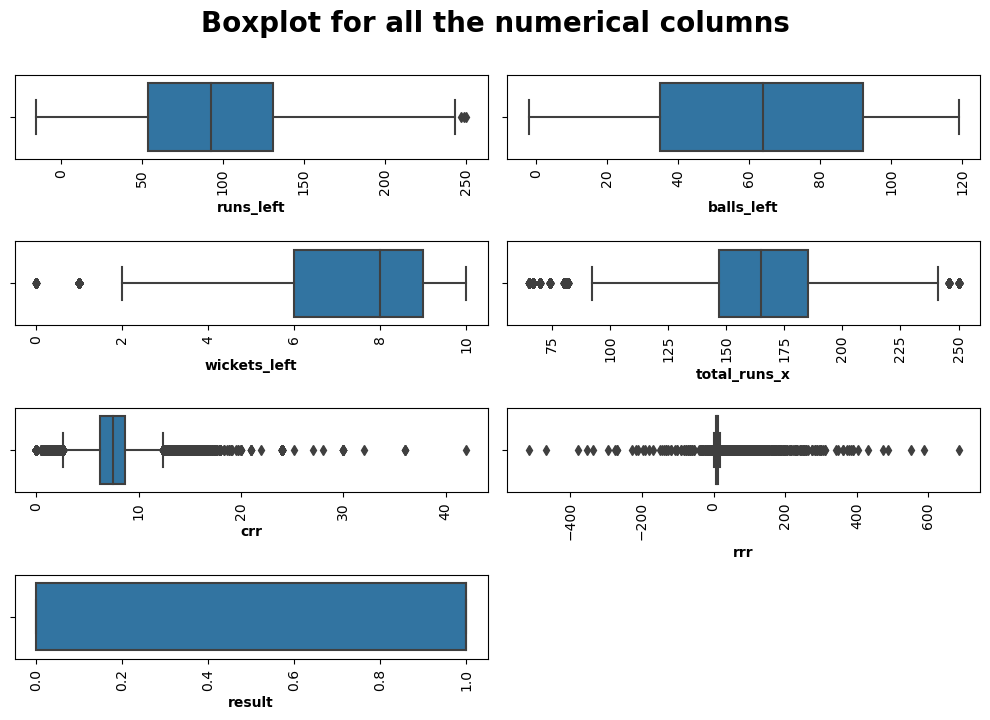

In [31]:
#check out the boxplot of all numerical features

def boxplot(data):
    plt.figure(figsize=(10,7),dpi=100)
    plt.suptitle('Boxplot for all the numerical columns',fontsize=20,fontweight='bold',alpha =1,y =1.01)
    
    i=0
    for col in data:
        if data[col].dtype !='object' : 
            plt.subplot(4,2,i+1)
            sns.boxplot(col,data=data)
            plt.tight_layout()
            plt.xlabel(col,fontdict={'fontsize':10,'fontweight':'bold'})
            plt.xticks(rotation='vertical')
            i=i+1
            
boxplot(final_df)

#the final_df has alot of outliers in each feature.
#since the problem is classification problem so the effect will be less of outliers on build model

# Feature Engineering

In [32]:
#Dividing the input and output feature of dataframe
x = final_df.drop(columns=['result'])
y = final_df.result
print('The shape of x (Dataframe excluding result from final_df is :',x.shape)
print('The shape of y (final_df result feature is :',y.shape)

The shape of x (Dataframe excluding result from final_df is : (71342, 9)
The shape of y (final_df result feature is : (71342,)


In [33]:
#train test splitting for training the best model
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.2,random_state=1)

print('Shape of x_train:',x_train.shape)
print('Shape of x_test:',x_test.shape)

#training ctegorical columns
train_cat_cols = x_train.select_dtypes(include = 'object').columns
print('Categorical Columns in training dataset:',train_cat_cols)
print('='*125)

#training numerical columns
train_num_cols = x_train.select_dtypes(include = ['int64','float64']).columns
print('Numerical Columns in training dataset:',train_num_cols)

Shape of x_train: (57073, 9)
Shape of x_test: (14269, 9)
Categorical Columns in training dataset: Index(['batting_team', 'bowling_team', 'city'], dtype='object')
Numerical Columns in training dataset: Index(['runs_left', 'balls_left', 'wickets_left', 'total_runs_x', 'crr',
       'rrr'],
      dtype='object')


In [34]:
#performing encoding on categorical column - OHE 

encoding_param = [('OHE',OneHotEncoder(sparse=False,drop='first'),['batting_team','bowling_team','city'])]

trf_OHE = ColumnTransformer(transformers=encoding_param,remainder='passthrough')


In [35]:
#feature scaling of all the feature of extracted data
scaling_param = [('scale',StandardScaler(),slice(0,48))]

trf_scale = ColumnTransformer(transformers=scaling_param)

In [36]:
#feature selection

In [37]:
#define the steps of pipeline for above column transformers
 
pipe_steps = [
    ('trf_OHE',trf_OHE),
    ('trf_scale',trf_scale)
]

#create an object of pipeline
pipeline = Pipeline(pipe_steps)

#display pipline
set_config(display='diagram')

pipeline

Pipeline(steps=[('trf_OHE',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('OHE',
                                                  OneHotEncoder(drop='first',
                                                                sparse=False),
                                                  ['batting_team',
                                                   'bowling_team', 'city'])])),
                ('trf_scale',
                 ColumnTransformer(transformers=[('scale', StandardScaler(),
                                                  slice(0, 48, None))]))])

In [39]:
#define the steps of pipeline for above column transformers
pipeline.fit_transform(x_train)

#display pipline
set_config(display='diagram')

pipeline

Pipeline(steps=[('trf_OHE',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('OHE',
                                                  OneHotEncoder(drop='first',
                                                                sparse=False),
                                                  ['batting_team',
                                                   'bowling_team', 'city'])])),
                ('trf_scale',
                 ColumnTransformer(transformers=[('scale', StandardScaler(),
                                                  slice(0, 48, None))]))])

In [40]:
#stepwise implementation on x_train
x_train_copy = x_train.copy()

In [41]:
#apply Onehotencoding 
encoding = pipeline['trf_OHE'].fit_transform(x_train_copy)
#pd.DataFrame(encoding)
encoding

array([[  0.        ,   0.        ,   0.        , ..., 165.        ,
          8.24347826,   9.6       ],
       [  0.        ,   0.        ,   0.        , ..., 163.        ,
          7.625     ,  10.5       ],
       [  0.        ,   0.        ,   0.        , ..., 190.        ,
         10.0776699 ,   6.35294118],
       ...,
       [  0.        ,   1.        ,   0.        , ..., 158.        ,
          4.2       ,   8.29090909],
       [  0.        ,   0.        ,   0.        , ..., 189.        ,
         11.4       ,   9.32727273],
       [  1.        ,   0.        ,   0.        , ..., 157.        ,
          7.10526316,   8.26829268]])

In [42]:
#applying scaling 
scaling = pipeline['trf_scale'].fit_transform(encoding)
#pd.DataFrame(scaling )
scaling

array([[-0.4032613 , -0.37004729, -0.39562338, ..., -0.02476269,
         0.34727388, -0.06937843],
       [-0.4032613 , -0.37004729, -0.39562338, ..., -0.09304042,
         0.07620479, -0.00550659],
       [-0.4032613 , -0.37004729, -0.39562338, ...,  0.82870902,
         1.15117061, -0.29981799],
       ...,
       [-0.4032613 ,  2.70235729, -0.39562338, ..., -0.26373477,
        -1.42491768, -0.16228292],
       [-0.4032613 , -0.37004729, -0.39562338, ...,  0.79457015,
         1.73072665, -0.08873353],
       [ 2.4797817 , -0.37004729, -0.39562338, ..., -0.29787363,
        -0.15158751, -0.16388797]])

In [43]:
#running all the steps in pipeline altogether
x_train_trf = pipeline.fit_transform(x_train)
y_train_trf = y_train

pd.DataFrame(x_train_trf).head()

,0,1,2,3,4,5,6,7,8,9,...,38,39,40,41,42,43,44,45,46,47
0,-0.403261,-0.370047,-0.395623,2.648961,-0.364486,-0.390722,-0.357105,-0.345268,-0.387170,-0.358351,...,-0.088747,-0.099185,-0.097825,-0.120361,-1.711375,-1.738890,-1.199693,-0.024763,0.347274,-0.069378
1,-0.403261,-0.370047,-0.395623,2.648961,-0.364486,-0.390722,-0.357105,-0.345268,2.582848,-0.358351,...,-0.088747,-0.099185,-0.097825,-0.120361,-1.031275,-1.167682,-0.729738,-0.093040,0.076205,-0.005507
2,-0.403261,-0.370047,-0.395623,-0.377506,-0.364486,-0.390722,2.800299,2.896299,-0.387170,-0.358351,...,-0.088747,-0.099185,-0.097825,-0.120361,-1.511345,-1.378127,0.680127,0.828709,1.151171,-0.299818
3,-0.403261,-0.370047,2.527656,-0.377506,-0.364486,-0.390722,-0.357105,-0.345268,-0.387170,-0.358351,...,-0.088747,-0.099185,-0.097825,-0.120361,-1.151292,-1.107555,-0.259783,-0.024763,0.371114,-0.161092
4,-0.403261,-0.370047,-0.395623,-0.377506,-0.364486,2.559363,-0.357105,-0.345268,-0.387170,-0.358351,...,-0.088747,-0.099185,-0.097825,-0.120361,0.488948,-0.386028,-1.199693,0.965264,-0.373036,0.254239


In [44]:
#runnig all the steps in pipeline altogether 
x_test_trf = pipeline.transform(x_test)
y_test_trf = y_test

#create dataframe of transformed x_test
pd.DataFrame(x_test_trf).head()

,0,1,2,3,4,5,6,7,8,9,...,38,39,40,41,42,43,44,45,46,47
0,2.479782,-0.370047,-0.395623,-0.377506,-0.364486,-0.390722,-0.357105,-0.345268,-0.387170,-0.358351,...,-0.088747,-0.099185,-0.097825,-0.120361,-1.671369,-1.618636,-1.199693,0.350765,0.690691,-0.277553
1,-0.403261,2.702357,-0.395623,-0.377506,-0.364486,-0.390722,-0.357105,-0.345268,-0.387170,-0.358351,...,-0.088747,-0.099185,-0.097825,-0.120361,-0.891254,-0.506283,-0.259783,1.340792,2.313526,-0.297095
2,2.479782,-0.370047,-0.395623,-0.377506,-0.364486,-0.390722,-0.357105,-0.345268,-0.387170,-0.358351,...,-0.088747,-0.099185,-0.097825,-0.120361,0.408936,0.185180,-0.729738,0.692154,0.498375,-0.047162
3,-0.403261,-0.370047,-0.395623,2.648961,-0.364486,-0.390722,-0.357105,-0.345268,2.582848,-0.358351,...,-0.088747,-0.099185,-0.097825,-0.120361,0.228910,-0.115456,0.210172,0.077654,-0.506677,0.007123
4,2.479782,-0.370047,-0.395623,-0.377506,-0.364486,-0.390722,-0.357105,-0.345268,-0.387170,-0.358351,...,-0.088747,-0.099185,-0.097825,-0.120361,-1.111287,-0.596473,0.210172,-0.400290,0.730073,-0.374379


# Model Implementation 

In [45]:
#models dict for slection of best model
models = {'Logistic Classifier':LogisticRegression(solver='liblinear'),
          'RandomForestClassifier' : RandomForestClassifier()
          }

In [46]:
for model in models.values():
    print(model)

LogisticRegression(solver='liblinear')
RandomForestClassifier()


In [47]:
#creating a function to compare model metrices performance

def compare_models(models:dict):
    metrics = {'Models':models.keys(), 'accuracy_score': []}
    
    for model in models.values():
        #create object of looped model
        model_object = model
        
        #fit the model
        model.fit(x_train_trf,y_train_trf)
        
        #predict the required accuracy score and precission score
        y_pred = model_object.predict(x_test_trf)
        
        #calculate the accuracy and precision score
        accuracy_s = accuracy_score(y_test_trf,y_pred)
        
        
        #appending the fetched score against the looped model
        metrics['accuracy_score'].append(accuracy_s)
        
        
        
    #create a dataframe fetched accuracy_scores and precision scores
    models_metrics = pd.DataFrame(metrics)
    return models_metrics
                    

In [48]:
#Dataframe of model vs performance metrics obtained
model_without_paramtunning = compare_models(models)

model_without_paramtunning

#Even though the accuracy_score of Random forest classifier comes out to be more but the value is very high 99%.
#We will use Logistic regression because the sigmoid function in the Logistic regression give good result during probability problem

,Models,accuracy_score
0,Logistic Classifier,0.799986
1,RandomForestClassifier,0.998949


In [49]:
#flow of prediction of probability of x_test
LR = LogisticRegression(solver='liblinear')
LR.fit(x_train_trf,y_train_trf)
Loss_prob = LR.predict_proba(x_test_trf).T[0]
win_prob = LR.predict_proba(x_test_trf).T[1]
np.round(win_prob*100,1)

array([46.8, 89.4,  4.4, ..., 97.9, 85.3, 87.8])

In [50]:
#Visual representation of predictive model on whole match ball wise

pipe_steps1 = [
    ('trf_OHE',trf_OHE),
    ('trf_scale',trf_scale),
    ('Logistic_model',LogisticRegression(solver='liblinear'))
]

#create an object of pipeline
pipeline1 = Pipeline(pipe_steps1)

#display pipline
set_config(display='diagram')

pipeline1


pipeline1.fit(x_train,y_train)

Pipeline(steps=[('trf_OHE',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('OHE',
                                                  OneHotEncoder(drop='first',
                                                                sparse=False),
                                                  ['batting_team',
                                                   'bowling_team', 'city'])])),
                ('trf_scale',
                 ColumnTransformer(transformers=[('scale', StandardScaler(),
                                                  slice(0, 48, None))])),
                ('Logistic_model', LogisticRegression(solver='liblinear'))])

In [51]:
#lets make a match_progression function in order to represent the prediction during each ball of a particular match.
#will pass the dataframe, match_id and pipe build

def match_progression(x_df,match_id,pipe):
    match= x_df[x_df['match_id'] == match_id]
    match = match[match['ball'] == 6]
    
    
    temp_df = match[['batting_team','bowling_team','city','runs_left','balls_left','wickets_left','total_runs_x','crr','rrr']].dropna()
    
    temp_df = temp_df[temp_df['balls_left'] != 0] 
    
    result = pipe.predict_proba(temp_df)
    temp_df['loss'] = np.round(result.T[0]*100,1)
    temp_df['win'] = np.round(result.T[1]*100,1)
    temp_df['end_of_over'] = range(1,temp_df.shape[0]+1)
    
    target = temp_df['total_runs_x'].values[0]
    runs = list(temp_df['runs_left'].values)
    new_runs = runs[:]
    runs.insert(0,target)
    temp_df['runs_after_over'] = np.array(runs)[:-1] - np.array(new_runs)
    wickets = list(temp_df['wickets_left'].values)
    new_wickets = wickets[:]
    new_wickets.insert(0,10)
    wickets.append(0)
    w = np.array(wickets)
    nw = np.array(new_wickets)
    temp_df['wickets_in_over'] = (nw-w)[0:temp_df.shape[0]]
    
    print('Target - ',target)
    temp_df = temp_df[['end_of_over','runs_after_over','wickets_in_over','loss','win']]
    return temp_df,target
    

In [52]:
temp_df, target= match_progression(delivery_df,74,pipeline1)
temp_df

Target -  178


,end_of_over,runs_after_over,wickets_in_over,loss,win
10459,1,3,0,57.5,42.5
10467,2,8,0,52.3,47.7
10473,3,1,0,59.1,40.9
10479,4,7,1,70.6,29.4
10485,5,12,0,60.7,39.3
10491,6,13,0,48.4,51.6
10497,7,9,0,42.4,57.6
10505,8,15,0,28.3,71.7
10511,9,7,0,26.1,73.9
10518,10,17,0,14.2,85.8


Text(0.5, 1.0, 'Target-178')

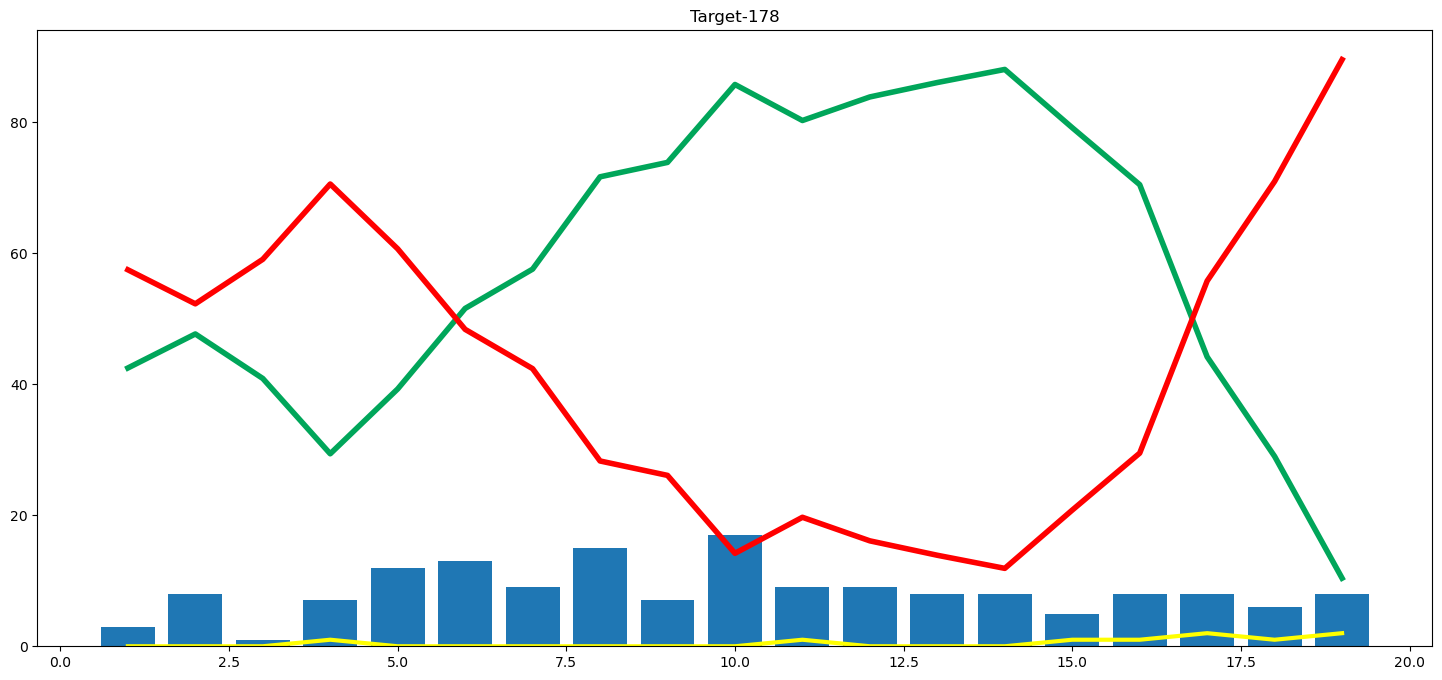

In [53]:
plt.figure(figsize=(18,8))
plt.plot(temp_df['end_of_over'],temp_df['wickets_in_over'],color='yellow',linewidth=3)
plt.plot(temp_df['end_of_over'],temp_df['win'],color='#00a65a',linewidth=4)
plt.plot(temp_df['end_of_over'],temp_df['loss'],color='red',linewidth=4)
plt.bar(temp_df['end_of_over'],temp_df['runs_after_over'])
plt.title('Target-' + str(target))

In [ ]:
import pickle
pickle.dump(pipeline1,open('pipeline1.pkl','wb'))

# Summary of Project

### **The summary of the steps executed in ML model are:**

**1. Data collection and overview of the dataframe:**
- The data was extracted from csv file downloaded from kaggle (matches.csv and delievry.csv).
- There were 756 matches played from the year 2008 - 2019 as depicted by matches dataframe.
- There were 179078 rows and 21 columns depicting the various details of match played in IPL ballwise.
- Intution of the dataframes was gained by calling the first five and last five rows of the given dataframe.
- There were ~1.4% values (feature city) and the same was droped by calling dropna() function.

Since we are going to find the probability of winng and lossing after each over similar to various app available in market.
we will be fetching the below feature from above two available dataframe:

- batting_team 
- bowling_team 
- city (where corresponding match was played)
- runs_lefts (pending runs to win the match after that corresponding ball during the second innings)
- balls_left (pending balls that can be played after that corresponding ball during the second innings) 
- wickets_left (No of wickets left of the batting team in the second innings at that state of time)
- total_runs_x (Represent the target runs to secure i.e first inning score)
- ccr (Current run rate)
- rrr (required run rate)
- result (whether the match was win by the current team at the corresponding ball)

Above feature was obtained with intuitive implementation of various libraries and new features was constructed
Based upon above our machine learning program will be trained to predict the probability of the match winner team.


**2. Feature Engineering:**

Below feature was constructed to reach our final dataframe:
- batting_team : Feature already available in the delivery dataframe.
- bowling_team : Feature already available in the delivery dataframe.
- city : Feature already available in the matches dataframe.
- runs_lefts : calculated based upon the target set in the first inning of each match (Merge, groupby etc function was used) 
- balls_left : was fetched by the formula (126 - delivery_df['over']*6 - delivery_df['ball']) from the merged delivery dataframe 
- wickets_left : was fetched by the formula (10- delivery_df.groupby('match_id').cumsum()['player_dismissed']) from the merged delivery
- total_runs_x : fetched from the target set during the first inning with the help of groupby function.
- ccr (Current run rate) : calculated from merged delivery datafram
- rrr (required run rate) : calculated from merged delivery datafram
- result : Function created. if the balling team wins than it return 1 else 0.

At last final_df was created having above 10 features 

Note: 
- we need to eliminate the rows where dlapplied was true as the same is not the parameter for prediction
- we also need to remove NaN values coming in the rrr feature
- In view of stat obtained for the final_df dataframe, there inf and inf values in the rrr feature. The same occured due to presence of 0 in the ball_left feature. So all the 0 values in ball_left feature was dropped out.


In order to create randomness in the dataframe sampling was done.

After obtaining the final_df, One hot encoding was implementated to batting_team,bowling_team and city which returned an array of 48 columns.
Thereafter scaling was implemented to all the 48 columns obtained after encoding.

In order to ease out the process of transformation of columns, columntransformer fucntion was called and finally a Pipe named pipeline was called.

**3. Exploratory Data Analysis:**

- Dist and QQ plot was ploted for numerical columns which depicted none of the numerical columns are normally distributed. Reason being presence of outliers.
- Boxplot was also plotted for numerical columns.


**5. Model Building:**

- Train test split was performed with test_size as 10% and random state of 1.
- Further **two** model namely **Logistic Regression** and **Random forest calssifier** was fitted for the splitted data set and various accuracy_score/prescission score was fetched.


Even though the accuracy_score of Random forest classifier comes out to be more but the value is very high 99%.
We will use Logistic regression because the sigmoid function in the Logistic regression give good result during probability problem.

Finally a pipe named pipeline1 was constructed which includes the Model Logistic Regression and above Columntransformers.

**5. Conclusion:**

**IMPORTANT IMPLEMANTATION:**

As the end goal was to check the probability of win and lose at end of each over, self has created one function named match_progression provide the target (Runs during first inning) and a dataframe. The dataframe obtained from the the said function will provide the probability of lose and win after each over for a particular match. Other details like runs made in that over and wicket gone in that over will also be depicting in that dataframe.

Graph of various parameter of match condition was displayed to know the trend of winning and losing percent after each over. 